In [30]:
# Importing required libraries
import pickle
import nltk
import pandas as pd

# preprocessing dependencies
from nltk.corpus import stopwords
from textblob import Word
from sklearn.preprocessing import LabelEncoder
from collections import Counter

# model dependencies
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, GlobalAveragePooling1D, Dropout, TimeDistributed, RepeatVector, Input
from sklearn.model_selection import train_test_split 
from keras.metrics import Precision, Recall

# plot dependencies
import matplotlib.pyplot as plt
import wordcloud

In [31]:
data = pd.read_csv('dataset.csv')
df = data[:20000].copy()                                                # Create copy of pandas DataFrame
df['humor'] = df['humor'].map({True: 1, False: 0})  # Replace boolean by string
df.head()

,text,humor
0,"Joe biden rules out 2020 bid: 'guys, i'm not r...",0
1,Watch: darvish gave hitter whiplash with slow ...,0
2,What do you call a turtle without its shell? d...,1
3,5 reasons the 2016 election feels so personal,0
4,"Pasco police shot mexican migrant from behind,...",0


In [32]:
#EDA Data Cleaning
# check the distribution of values
df['humor'].value_counts()

1    10051
0     9949
Name: humor, dtype: int64

In [33]:
# check NaN values
print(df.isna().sum())
# drop NaN values
df = df.dropna()

text     0
humor    0
dtype: int64


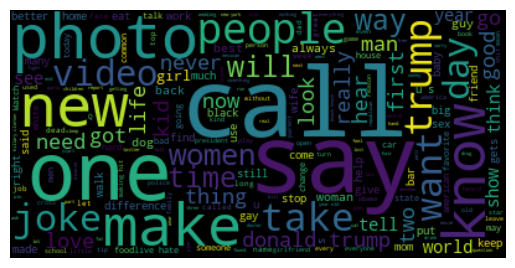

In [34]:
# check common words with the word cloud
common_words=''
for i in df.text:  
    i = str(i)
    tokens = i.split()
    common_words += " ".join(tokens)+" "
wordcloud = wordcloud.WordCloud().generate(common_words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [9]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('popular')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rafique\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Rafique\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     C:\Users\Rafique\AppData\Roaming\nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     C:\Users\Rafique\AppData\Roaming\nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     C:\Users\Rafique\AppData\Roaming\nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     C:\Users\Rafique\AppD

True

In [35]:
# clean dataset
def cleaning(df, stop_words):
    df['text'] = df['text'].apply(lambda x:' '.join(x.lower() for x in x.split()))
    # Replacing the digits/numbers
    df['text'] = df['text'].str.replace('^\d+\s|\s\d+\s|\s\d+$', '')
    # Removing stop words
    df['text'] = df['text'].apply(lambda x:' '.join(x for x in x.split() if x not in stop_words))
    # Lemmatization
    df['text'] = df['text'].apply(lambda x:' '.join([Word(x).lemmatize() for x in x.split()]))
    return df

stop_words = stopwords.words('english')
data_v1 = cleaning(df, stop_words)
data_v1.head()

C:\Users\Rafique\AppData\Local\Temp\ipykernel_8568\3647938611.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df['text'] = df['text'].str.replace('^\d+\s|\s\d+\s|\s\d+$', '')


,text,humor
0,"joe biden rule outbid: 'guys, i'm running'",0
1,watch: darvish gave hitter whiplash slow pitch,0
2,call turtle without shell? dead.,1
3,reason theelection feel personal,0
4,"pasco police shot mexican migrant behind, new ...",0


In [36]:
# Encoded the target column
lb=LabelEncoder()
data_v1['humor'] = lb.fit_transform(data_v1['humor'])
data_v1.head()

,text,humor
0,"joe biden rule outbid: 'guys, i'm running'",0
1,watch: darvish gave hitter whiplash slow pitch,0
2,call turtle without shell? dead.,1
3,reason theelection feel personal,0
4,"pasco police shot mexican migrant behind, new ...",0


In [37]:
# tokenize input text
tokenizer = Tokenizer(num_words=500, split=' ') 
tokenizer.fit_on_texts(data_v1['text'].values)
X = tokenizer.texts_to_sequences(data_v1['text'].values)
X = pad_sequences(X)

In [38]:
# saving tokenizer
with open('tokenizer_LSTM.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [39]:
# Splitting the data into training and testing
y = pd.get_dummies(data_v1['humor'])
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 42)

In [40]:
X.shape[1]

13

In [41]:
# create model architecture
model = Sequential()
model.add(Embedding(500, 120, input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(176, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', 
              optimizer='adam', 
              metrics = ['accuracy', Precision(), Recall()])
print(model.summary())


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 13, 120)           60000     
                                                                 
 spatial_dropout1d_2 (Spatia  (None, 13, 120)          0         
 lDropout1D)                                                     
                                                                 
 lstm_2 (LSTM)               (None, 176)               209088    
                                                                 
 dense_2 (Dense)             (None, 2)                 354       
                                                                 
Total params: 269,442
Trainable params: 269,442
Non-trainable params: 0
_________________________________________________________________
None


In [47]:
# run model 
batch_size=32
history = model.fit(X_train, y_train, 
                    validation_data = (X_test, y_test),
                    epochs = 10, batch_size = batch_size, 
                    verbose = 'auto')

Epoch 1/10
438/438 [==============================] - 27s 62ms/step - loss: 0.3584 - accuracy: 0.8350 - precision_2: 0.8350 - recall_2: 0.8350 - val_loss: 0.3974 - val_accuracy: 0.8177 - val_precision_2: 0.8177 - val_recall_2: 0.8177
Epoch 2/10
438/438 [==============================] - 27s 62ms/step - loss: 0.3506 - accuracy: 0.8413 - precision_2: 0.8413 - recall_2: 0.8413 - val_loss: 0.3994 - val_accuracy: 0.8193 - val_precision_2: 0.8193 - val_recall_2: 0.8193
Epoch 3/10
438/438 [==============================] - 27s 62ms/step - loss: 0.3439 - accuracy: 0.8427 - precision_2: 0.8427 - recall_2: 0.8427 - val_loss: 0.4080 - val_accuracy: 0.8215 - val_precision_2: 0.8215 - val_recall_2: 0.8215
Epoch 4/10
438/438 [==============================] - 27s 63ms/step - loss: 0.3377 - accuracy: 0.8422 - precision_2: 0.8422 - recall_2: 0.8422 - val_loss: 0.4082 - val_accuracy: 0.8190 - val_precision_2: 0.8190 - val_recall_2: 0.8190
Epoch 5/10
438/438 [==============================] - 27s 63ms/s

In [48]:
# Analyze the model using the test data.
model.evaluate(X_test,y_test)

188/188 [==============================] - 2s 9ms/step - loss: 0.4500 - accuracy: 0.8102 - precision_2: 0.8102 - recall_2: 0.8102


[0.44996485114097595,
 0.8101666569709778,
 0.8101666569709778,
 0.8101666569709778]

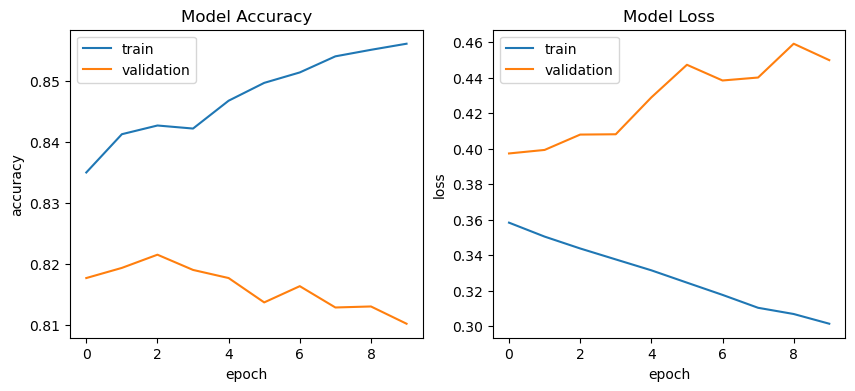

In [49]:
def plot_training_hist(history):
    '''Plot history for accuracy and loss'''
    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    # first plot
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')
    # second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')
    
plot_training_hist(history)

188/188 [==============================] - 2s 9ms/step


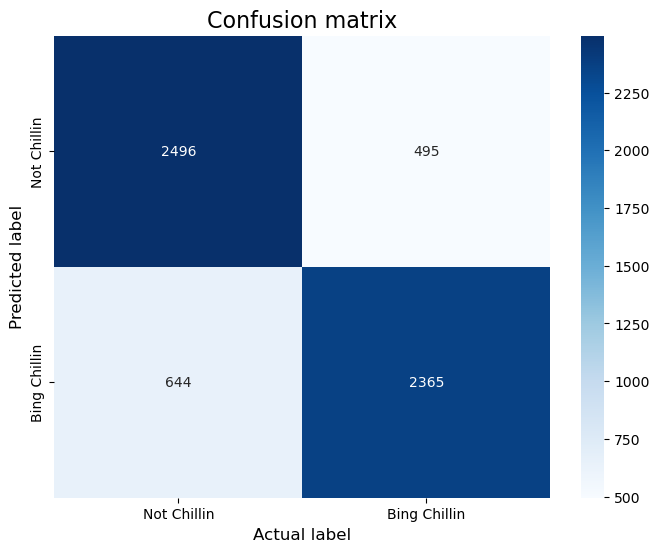

In [50]:
# check the model's performance on testing data
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns 

def plot_confusion_matrix(model, X_test, y_test):
    '''Function to plot confusion matrix for the passed model and the data'''
    
    sentiment_classes = ['Not Chillin', 'Bing Chillin']
    # use the model to do the prediction
    y_pred = model.predict(X_test)
    # compute the confusion matrix
    cm = confusion_matrix(np.argmax(np.array(y_test),axis=1), np.argmax(y_pred, axis=1))
    # plot confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)
    
plot_confusion_matrix(model, X_test, y_test)

In [51]:
# save model
model.save('model_LSTM.h5')